<h1><center>CS 513 Knowledge Discovery and Data Mining</center></h1>
<h1><center>Multiclass Object Classification in Autonomous Driving</center></h1>
<h3>Group Members</h3>
<h4>Bhushan Asati</h4>
<h4>Suyash Madhavi</h4>
<h4>Anirudh Sharma</h4>
<h4>Rujuta Dabke</h4>

Multiclass Object Classification using the KITTI Dataset Models in this script:

- RandomForest
- XGBoost
- Faster R-CNN

This script includes:

1) Kaggle API setup and dataset download
2) Data Loading and Preprocessing
3) Training the models
4) Evaluating the models
5) Annotating outputs
6) Saving models

In [1]:
!pip install tensorflow_addons xgboost > /dev/null
!pip install shap > /dev/null
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118 > /dev/null

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pickle
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Additional imports for traditional ML models
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb


In [4]:
# For Faster R-CNN
import torch
import torchvision
from torchvision import transforms as T
from PIL import Image

# Kaggle API Setup and Dataset Download

1. **Upload Kaggle API Key**:
   - The `kaggle.json` file contains your Kaggle credentials.
   - Upload it to Colab using the `files.upload()` method.

In [ ]:
from google.colab import files
files.upload()

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!mv ~/.kaggle/kaggle.json /root/.config/kaggle/

mv: cannot move '/root/.kaggle/kaggle.json' to '/root/.config/kaggle/': Not a directory


In [7]:
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

# 2) Data Loading and Preprocessing

1. **Dataset Download**:
   - Download the KITTI dataset using the Kaggle API.
   - Extract the dataset into image and label directories.

2. **Simplifying Categories**:
   - Map original KITTI classes to two categories: `Human` (e.g., Pedestrian, Cyclist) and `Vehicle` (e.g., Car, Truck).
   - Ignore irrelevant classes (`Misc`, `DontCare`).

3. **Image and Label Processing**:
   - Resize images to `224x224`, normalize, and convert to RGB.
   - Map labels to simplified categories.

4. **Data Splitting**:
   - Split data into training, validation, and test sets with balanced class proportions.

5. **Handling Class Imbalance**:
   - Compute class weights to mitigate imbalance during model training.

6. **Data Augmentation**:
   - Apply augmentation (rotation, flipping, zooming) to the training data.

In [8]:
dataset_name = 'garymk/kitti-3d-object-detection-dataset'
dataset_path = '/content/kitti_dataset/'

In [9]:
if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)
    !kaggle datasets download -d {dataset_name} -p {dataset_path}
    !unzip -q {dataset_path}kitti-3d-object-detection-dataset.zip -d {dataset_path}
    print("Dataset downloaded and extracted successfully.")
else:
    print("Dataset already exists. Skipping download.")


Dataset URL: https://www.kaggle.com/datasets/garymk/kitti-3d-object-detection-dataset
License(s): unknown
100% 30.0G/30.0G [04:08<00:00, 95.4MB/s]
100% 30.0G/30.0G [04:08<00:00, 130MB/s] 
Dataset downloaded and extracted successfully.


In [10]:
image_dir = os.path.join(dataset_path, 'training/image_2/')
label_dir = os.path.join(dataset_path, 'training/label_2/')
image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]

In [11]:
class_mapping = {
    'Pedestrian': 'Human',
    'Person_sitting': 'Human',
    'Cyclist': 'Human',
    'Car': 'Vehicle',
    'Truck': 'Vehicle',
    'Van': 'Vehicle',
    'Tram': 'Vehicle',
    'Misc': None,
    'DontCare': None
}


In [12]:
TARGET_SIZE = (224, 224)
def map_label(label_path):
    with open(label_path, 'r') as f:
        lines = f.readlines()
        mapped_classes = []
        for line in lines:
            data = line.strip().split()
            obj_class = data[0]
            mapped_class = class_mapping.get(obj_class)
            if mapped_class is not None:
                mapped_classes.append(mapped_class)
        return mapped_classes

In [13]:
images = []
labels = []

In [14]:
for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)
    label_path = os.path.join(label_dir, image_file.replace('.png', '.txt'))

    image = cv2.imread(image_path)
    image_resized = cv2.resize(image, TARGET_SIZE)
    image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)

    mapped_classes = map_label(label_path)
    if mapped_classes and len(mapped_classes) > 0:
        images.append(image_rgb)
        labels.append(mapped_classes[0])
    else:
        # Skip images that don't map to our simplified classes
        continue

X = np.array(images)
y = np.array(labels)


In [15]:
X = X / 255.0  # Normalize


In [16]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
class_names = list(label_encoder.classes_)
print("Reduced Categories:", class_names)  # Expect ["Human", "Vehicle"]

Reduced Categories: ['Human', 'Vehicle']


In [17]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)


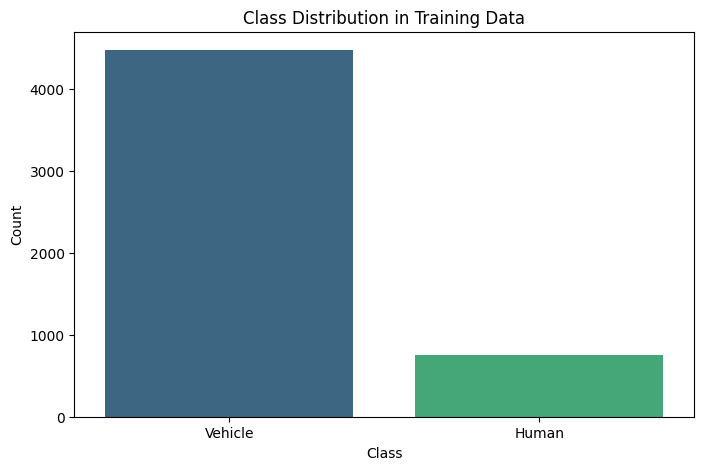

In [18]:
label_counts = Counter(y_train)
plt.figure(figsize=(8, 5))
sns.barplot(x=[class_names[k] for k in label_counts.keys()],
            y=list(label_counts.values()), palette='viridis')
plt.title("Class Distribution in Training Data")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [19]:
# Class weights for imbalance
class_counts = Counter(y_train)
total_samples = len(y_train)
class_weights = {}
for class_idx, count in class_counts.items():
    class_weights[class_idx] = total_samples / (len(class_names) * count)

print("Class Weights:", class_weights)


Class Weights: {1: 0.5847665847665847, 0: 3.449275362318841}


In [20]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)
test_datagen = ImageDataGenerator()

# 3) Training the models

1. **Feature Extraction**:
   - DenseNet121 is used as a frozen feature extractor.
   - Features are extracted for training, validation, and test datasets using `GlobalAveragePooling2D`.

2. **Traditional Classifiers**:
   - **XGBoost**: Trained on extracted features for classification into "Human" and "Vehicle".
   - **Random Forest**: Another classifier trained on the same features.

3. **Faster R-CNN for Object Detection**:
   - Pretrained Faster R-CNN (ResNet-50 FPN) is used to predict bounding boxes and labels.
   - COCO classes are mapped to simplified categories (`Human` and `Vehicle`).

4. **Performance Analysis**:
   - Classifiers are evaluated on test data, while Faster R-CNN provides bounding boxes and predictions for individual images.


In [21]:
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 1e-4

In [22]:
train_gen = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
val_gen = test_datagen.flow(X_val, y_val, batch_size=BATCH_SIZE)
test_gen = test_datagen.flow(X_test, y_test, batch_size=BATCH_SIZE, shuffle=False)

In [33]:
feature_extractor = models.Sequential([
    densenet_base,
    layers.GlobalAveragePooling2D()
])
feature_extractor.trainable = False

In [34]:
def extract_features(model, X_data, batch_size=32):
    features = []
    for i in range(0, len(X_data), batch_size):
        batch = X_data[i:i+batch_size]
        batch_features = model.predict(batch)
        # No need for additional pooling since GlobalAveragePooling2D is included
        features.append(batch_features)
    return np.vstack(features)

In [35]:
X_train_features = extract_features(feature_extractor, X_train, BATCH_SIZE)
X_val_features = extract_features(feature_extractor, X_val, BATCH_SIZE)
X_test_features = extract_features(feature_extractor, X_test, BATCH_SIZE)

1/1 [==============================] - 0s 131ms/step


In [36]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train_features, y_train)
y_xgb_pred = xgb_model.predict(X_test_features)

# 4) Evaluating the Models

1. **XGBoost Classifier**:
   - Generate a classification report to evaluate metrics: precision, recall, F1-score, and accuracy.
   - Visualize a confusion matrix with a heatmap (`Oranges` colormap) to assess predictions for each class.

2. **Random Forest Classifier**:
   - Print a classification report for detailed metrics.
   - Plot a confusion matrix heatmap (`Greens` colormap) for better visualization of performance.

3. **Faster R-CNN**:
   - Evaluate Faster R-CNN predictions with a classification report.
   - Visualize the confusion matrix using a heatmap (`Blues` colormap).

4. **Performance Analysis**:
   - Classification reports and confusion matrices allow deeper insights into model performance, highlighting strengths and misclassifications.


In [37]:
print("Classification Report (XGBoost):")
print(classification_report(y_test, y_xgb_pred, target_names=class_names))

Classification Report (XGBoost):
              precision    recall  f1-score   support

       Human       0.96      0.94      0.95       163
     Vehicle       0.99      0.99      0.99       960

    accuracy                           0.98      1123
   macro avg       0.97      0.97      0.97      1123
weighted avg       0.98      0.98      0.98      1123



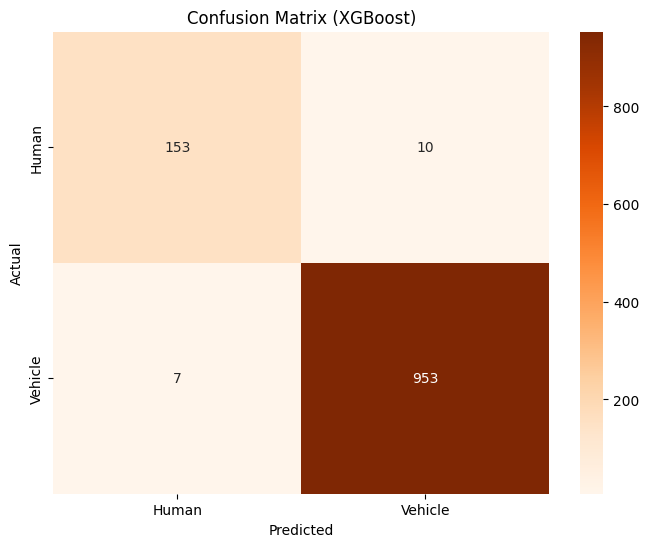

In [38]:
cm_xgb = confusion_matrix(y_test, y_xgb_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm_xgb, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Oranges')
plt.title('Confusion Matrix (XGBoost)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [39]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_features, y_train)
y_rf_pred = rf_model.predict(X_test_features)

In [40]:
print("Classification Report (Random Forest):")
print(classification_report(y_test, y_rf_pred, target_names=class_names))

Classification Report (Random Forest):
              precision    recall  f1-score   support

       Human       0.96      0.91      0.93       163
     Vehicle       0.99      0.99      0.99       960

    accuracy                           0.98      1123
   macro avg       0.97      0.95      0.96      1123
weighted avg       0.98      0.98      0.98      1123



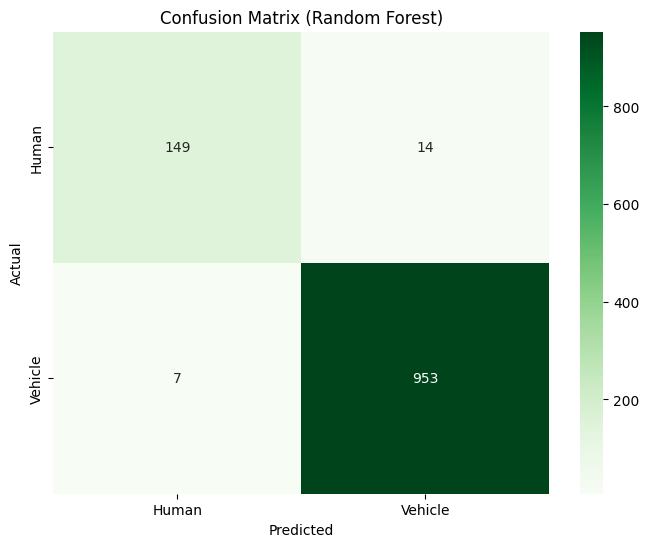

In [41]:
cm_rf = confusion_matrix(y_test, y_rf_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm_rf, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Greens')
plt.title('Confusion Matrix (Random Forest)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [42]:
faster_rcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
faster_rcnn.eval()

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 224MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [43]:
coco_to_ours = {
    1: 'Human',    # person
    2: 'Human',    # bicycle
    3: 'Vehicle',  # car
    # you can add more if needed, but let's keep it simple.
}

In [44]:
transform = T.Compose([T.ToTensor()])

In [45]:
# Let's pick one test image and run through Faster R-CNN
test_img_idx = 0
test_img = (X_test[test_img_idx]*255).astype(np.uint8)
pil_img = Image.fromarray(test_img)

In [46]:
with torch.no_grad():
    prediction = faster_rcnn([transform(pil_img)])[0]

pred_boxes = prediction['boxes'].cpu().numpy()
pred_scores = prediction['scores'].cpu().numpy()
pred_labels = prediction['labels'].cpu().numpy()


In [47]:
# Take highest scoring detection
if len(pred_scores) > 0:
    best_idx = np.argmax(pred_scores)
    best_label = pred_labels[best_idx]
    best_score = pred_scores[best_idx]

    if best_score > 0.5: # a confidence threshold
        # Map to our classes if possible
        ours_class = coco_to_ours.get(best_label, None)
        if ours_class is None:
            print("Faster R-CNN detected a class not mapped to Human/Vehicle.")
        else:
            print(f"Faster R-CNN predicted: {ours_class} with confidence {best_score:.2f}")
    else:
        print("No high confidence detections.")
else:
    print("No detections from Faster R-CNN.")

Faster R-CNN predicted: Vehicle with confidence 0.95


Classification Report (Faster R-CNN):
              precision    recall  f1-score   support

       Human       0.64      0.60      0.62       163
     Vehicle       0.93      0.94      0.94       960

    accuracy                           0.89      1123
   macro avg       0.79      0.77      0.78      1123
weighted avg       0.89      0.89      0.89      1123



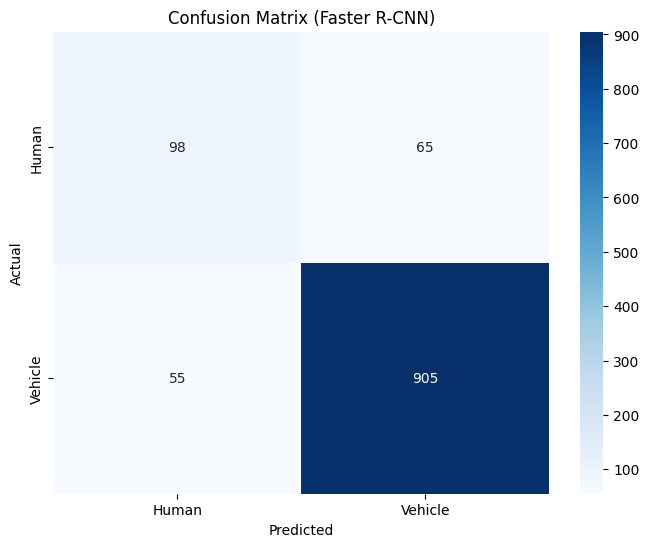

In [48]:
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torchvision
from torchvision import transforms as T
from PIL import Image
import numpy as np

# Assume we already have a pretrained model loaded as 'faster_rcnn'
# and a mapping dictionary 'coco_to_ours' as defined previously
# Example:
# coco_to_ours = {
#     1: 'Human',  # person
#     2: 'Human',  # bicycle
#     3: 'Vehicle' # car
# }

faster_rcnn.eval()
transform = T.Compose([T.ToTensor()])

y_frcnn_pred = []

# Loop through each test image, run inference, and map predictions
for i in range(len(X_test)):
    img = (X_test[i] * 255).astype(np.uint8)
    pil_img = Image.fromarray(img)
    with torch.no_grad():
        prediction = faster_rcnn([transform(pil_img)])[0]

    pred_scores = prediction['scores'].cpu().numpy()
    pred_labels = prediction['labels'].cpu().numpy()

    if len(pred_scores) > 0:
        # Take the highest confidence detection
        best_idx = np.argmax(pred_scores)
        best_label = pred_labels[best_idx]
        best_score = pred_scores[best_idx]

        if best_score > 0.5: # threshold to consider a detection valid
            # Map COCO label to ours if possible
            ours_class = coco_to_ours.get(best_label, None)
            if ours_class is None:
                # If unmapped, default to "Vehicle" or skip
                # For simplicity, let's default to Vehicle
                ours_class = "Vehicle"
        else:
            # If no confident detection, default to Vehicle or Human
            ours_class = "Vehicle"
    else:
        # No detections at all, default guess
        ours_class = "Vehicle"

    # Convert ours_class to encoded form (0 or 1)
    y_frcnn_pred.append(class_names.index(ours_class))

# Now we have predictions for the entire test set in y_frcnn_pred
print("Classification Report (Faster R-CNN):")
print(classification_report(y_test, y_frcnn_pred, target_names=class_names))

cm_frcnn = confusion_matrix(y_test, y_frcnn_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm_frcnn, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title('Confusion Matrix (Faster R-CNN)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
